In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
data_dir = 'data'
age_labels = []
image_paths = []

for filename in tqdm(os.listdir(data_dir)):
  image_path = os.path.join(data_dir, filename)
  img_components = filename.split('_')
  age_label = int(img_components[0])

  age_labels.append(age_label)
  image_paths.append(image_path)
    

print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

  0%|          | 0/23708 [00:00<?, ?it/s]

Number of age_labels: 23708, Number of image_paths: 23708


In [3]:
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,data\100_0_0_20170112213500903.jpg.chip.jpg,100
1,data\100_0_0_20170112215240346.jpg.chip.jpg,100
2,data\100_1_0_20170110183726390.jpg.chip.jpg,100
3,data\100_1_0_20170112213001988.jpg.chip.jpg,100
4,data\100_1_0_20170112213303693.jpg.chip.jpg,100


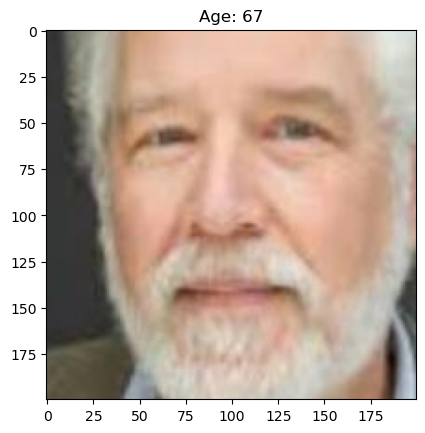

In [4]:
from PIL import Image

rand_idx = random.randint(0, len(image_paths))
age = df['age'][rand_idx]
img = Image.open(df['image_path'][rand_idx])
plt.title(f'Age: {age}')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

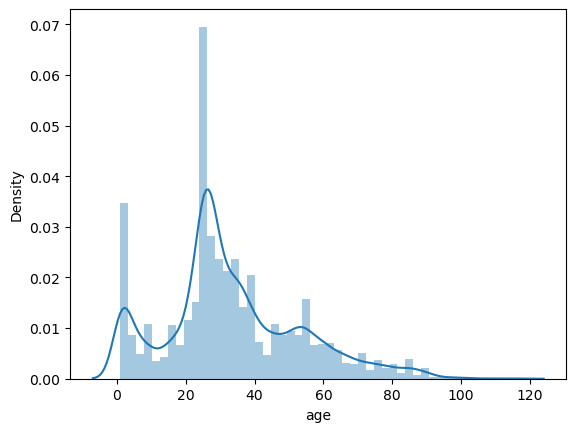

In [5]:
sns.distplot(df['age'])

In [6]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128, 128), Image.Resampling.LANCZOS) 
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [7]:
x = extract_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
x.shape

(23708, 128, 128, 1)

In [9]:
x = x / 255.0

In [10]:
y = np.array(df['age'])

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer for age prediction
model.add(Dense(1, activation='relu')) 


model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,747,649 (10.48 MB)

 Trainable params: 2,747,649 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(x=x, y=y, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 162s 269ms/step - loss: 11.7498 - mae: 11.7498 - val_loss: 33.8988 - val_mae: 33.8988
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 158s 266ms/step - loss: 8.0190 - mae: 8.0190 - val_loss: 30.1404 - val_mae: 30.1404
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 158s 266ms/step - loss: 7.0721 - mae: 7.0721 - val_loss: 28.7825 - val_mae: 28.7825
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 159s 267ms/step - loss: 6.5298 - mae: 6.5298 - val_loss: 24.4469 - val_mae: 24.4469
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 159s 269ms/step - loss: 6.2300 - mae: 6.2300 - val_loss: 26.0851 - val_mae: 26.0851
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 162s 272ms/step - loss: 5.9804 - mae: 5.9804 - val_loss: 22.6681 - val_mae: 22.6681
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 159s 268ms/step - loss: 5.6119 - mae: 5.6119 - val_loss: 25.2128 - val_mae: 25.2128
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 157s 265ms/step - loss: 5.4716 - mae: 5.4716 - val_loss: 20.1218 - val_mae: 20.1218
Epoch 

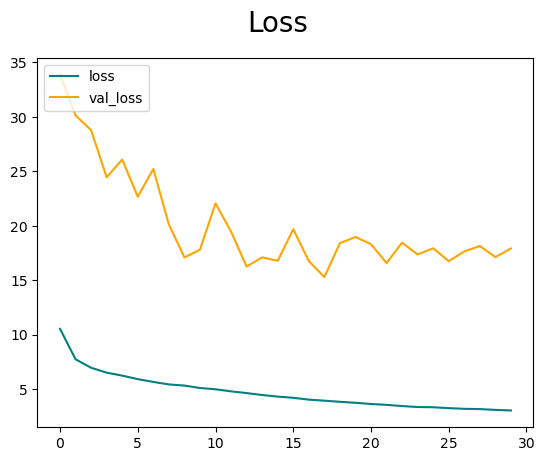

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

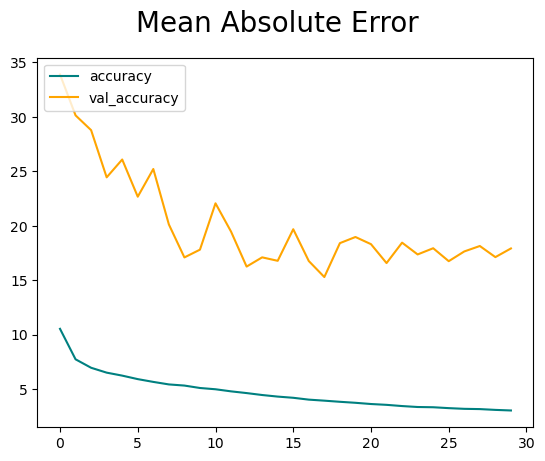

In [20]:
fig = plt.figure()
plt.plot(history.history['mae'], color='teal', label='accuracy')
plt.plot(history.history['val_mae'], color='orange', label='val_accuracy')
fig.suptitle('Mean Absolute Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
def get_image_features(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((128, 128), Image.Resampling.LANCZOS) 
    img = np.array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


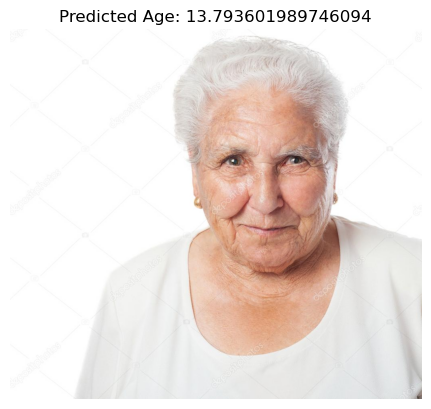

In [22]:
img_test = 'images/old_woman.jpg'
features = get_image_features(img_test)
pred = model.predict(features)
age = pred[0][0]

plt.title(f'Predicted Age: {age}')
plt.axis('off')
plt.imshow(np.array(load_img(img_test)))